In this notebook, I'll build a neural network with PyTorch to classify handwritten digits. I'll use the MNIST dataset, which consists of 70000 grayscale images of handwritten digits, like the ones showed bellow.

![mnist](Figures/MnistExamples.png)

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import torch
from tqdm.notebook import tqdm

First, I download the train and test sets of MNIST.

In [4]:
from torchvision import datasets, transforms

train_set = datasets.MNIST(root='./datasets', train=True, transform=transforms.ToTensor(), download=True)
test_set = datasets.MNIST(root='./datasets', train=False, transform=transforms.ToTensor(), download=True)

Failed to download (trying next):
HTTP Error 503: Service Unavailable



  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./datasets/MNIST/raw/train-images-idx3-ubyte.gz to ./datasets/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./datasets/MNIST/raw/train-labels-idx1-ubyte.gz to ./datasets/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./datasets/MNIST/raw/t10k-images-idx3-ubyte.gz to ./datasets/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./datasets/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./datasets/MNIST/raw

Processing...
Done!


In [5]:
print("Number of training examples: %d" % (len(train_set)))
print("Number of test examples: %d" % (len(test_set)))

Number of training examples: 60000
Number of test examples: 10000


I'll look at the first image from the train set and their label in order to understand the data.

Image shape: torch.Size([1, 28, 28])
Label: 5


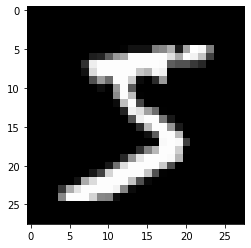

In [32]:
image, label = train_set[0]

print("Image shape: {}".format(image.shape))
image = image.reshape((28,28))
plt.imshow(image, cmap='gray')

print("Label: {}".format(label))

In [14]:
train_loader = torch.utils.data.DataLoader(train_set, batch_size = 100, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=100, shuffle = False)

In [18]:
images, labels = list(train_loader)[0]

print("Shape of the minibatch of images: {}".format(images.shape))
print("Shape of the minibatch of labels: {}".format(labels.shape))

Shape of the minibatch of images: torch.Size([100, 1, 28, 28])
Shape of the minibatch of labels: torch.Size([100])


## Logistic Regression Model

Convert minibatch of inputs images (tensors) into a minibatch of row vectors (of pixel values).

In [22]:
x = images.view(100,28*28)
print("Shape of input x: {}".format(x.shape))

Shape of input x: torch.Size([100, 784])


Given an input image, we'd like to get the predicted propability of the image being each of the digits from 0 to 9. Let $x_i$ be the input row vector associated with the $i$-th image, $w_{i,j}$ the weight vector associated with class $j$ (of digit $j$, so $0 \leq j \leq 9$) and image $i$, and $b_i$ the bias associated with image $i$. Then, for the $i$-th image, the probabilities of the image representing the digits 0 to 9 are:

\begin{align*}
y_0 =& \sum_i x_i w_{i,0} + b_0 \\
y_1 =& \sum_i x_i w_{i,1} + b_1 \\
y_2 =& \sum_i x_i w_{i,2} + b_2 \\
y_3 =& \sum_i x_i w_{i,3} + b_3 \\
y_4 =& \sum_i x_i w_{i,4} + b_4 \\
y_5 =& \sum_i x_i w_{i,5} + b_5 \\
y_6 =& \sum_i x_i w_{i,6} + b_6 \\
y_7 =& \sum_i x_i w_{i,7} + b_7 \\
y_8 =& \sum_i x_i w_{i,8} + b_8 \\
y_9 =& \sum_i x_i w_{i,9} + b_9
\end{align*}

This can be expressed in matrix form as:

\begin{align}
y = xW + b,
\end{align}

where $y$ is $10$-component vector (one component for each digit class), $x$ is the row vector associated with the image (in our case, it has 784 components), $W$ is a $784 \times 10$ matrix of weights, and b is the $10$-component vector of the bias values.

Since we have defined a minibatch of 100 inputs $x$ to process them all at once, we stack each input $x$ into a matrix $X$, obtaining

\begin{align}
Y = X W + b 
\end{align}

where $Y$ has dimensions $100 \times 10$ (100 images, 10 classes), X has dimensions $100 \times 784$, $W$ has dimensions $784 \times 10$ and $b$ is a vector of $10$ components.

The parameters of the model (that will have to be "learned") are $W$ and $b$.

In [23]:
# Initialize W randomly.
W = torch.randn(784,10)/np.sqrt(784)
W.requires_grad_()

# Initizalize b as a vector of 0s.
b = torch.zeros(10, requires_grad=True)

We compute $y$ as described above, with the random values for $W$, and 0s for $b$.

In [24]:
# Linear transform
y = torch.matmul(x,W) + b

In [28]:
print("The resulting y's for the first image are: \n", y[0,:])

The resulting y's for the first image are: 
 tensor([ 0.3035,  0.4193,  0.0178, -0.1323,  0.1265,  0.0604, -0.0826,  0.1776,
         0.1725,  0.0497], grad_fn=<SliceBackward>)


We normalize the values $y_i$ to be positive and be between 0 and 1, and that sum to 1. We do this with a softmax:

\begin{align}
p(y_i) = \text{softmax}(y_i) = \dfrac{\text{exp}(y_i)}{\sum_j{\text{exp}(y_j)}}
\end{align}

We then can interpret the obtained values as probabilities.

In [31]:
prob_y = torch.exp(y) / torch.sum(torch.exp(y), dim=1, keepdim=True)

print("The probabilities p(y) for the first image are:\n", prob_y[0])

The probabilities p(y) for the first image are:
 tensor([0.1197, 0.1343, 0.0899, 0.0774, 0.1002, 0.0938, 0.0813, 0.1055, 0.1050,
        0.0928], grad_fn=<SelectBackward>)


We now will adjust the parameters of the model, $W$ and $b$, while measuring the model's performance using the cross-entropy loss function:

\begin{align}
H_{y'}(y)=-\sum_i y'_i \text{log}(y_i)
\end{align}

where $y'_i$ is the true label, that we want our model to predict, and $N$ is the number of images we have.

In [34]:
import torch.nn.functional as F

cross_entropy = F.cross_entropy(y,labels)
print("Cross entropy: {}".format(cross_entropy))

Cross entropy: 2.3816354274749756


We adjust the parameters in a way that minimizes the loss, computed with the function above. We'll do this using the Stochastic Gradient Descent:

\begin{align}
\theta_{t+1} = \theta_t - \alpha \nabla_\theta \mathcal{L}
\end{align}

where $\theta$ is a parameter, $\alpha$ is a learning rate (step size), and $\nabla_\theta \mathcal{L}$ is the gradient of our loss with respect to $\theta$.

In [36]:
optimizer = torch.optim.SGD([W,b], lr=0.1)

In [37]:
# Compute the gradients of the loss function for W and b
cross_entropy.backward()

In [38]:
b.grad

tensor([-0.0014,  0.0439, -0.0520, -0.0483,  0.0202, -0.0007,  0.0281,  0.0193,
        -0.0264,  0.0172])

In [39]:
optimizer.step()

In [41]:
# b has been updated by -0.1*b.grad
b

tensor([ 1.3548e-04, -4.3949e-03,  5.1993e-03,  4.8287e-03, -2.0219e-03,
         6.9344e-05, -2.8095e-03, -1.9273e-03,  2.6397e-03, -1.7191e-03],
       requires_grad=True)

We've trained the model on a minibatch. We now repeat the process for the rest of the training data.

### Training

In [42]:
# Interate through the minibatchs of the train set
for images, labels in tqdm(train_loader):
    # Zero out the gradients (clear gradient buffers)
    optimizer.zero_grad()
    
    # Forward pass
    x = images.view(100,28*28)
    y = torch.matmul(x,W) + b
    cross_entropy = F.cross_entropy(y,labels)
    # Backward pass
    cross_entropy.backward()
    optimizer.step()


  0%|          | 0/600 [00:00<?, ?it/s]

### Testing

In [45]:
correct = 0
total = len(test_set)

# Turn off autograd engine to speed up evaluation
with torch.no_grad():
    # Iterate through test set minibatchs
    for images, labels in tqdm(test_loader):
        # Forward pass
        x = images.view(100,28*28)
        y = torch.matmul(x,W) + b
        
        predictions = torch.argmax(y,dim=1)
        correct += torch.sum((predictions == labels).float())
        
print('Test accuracy: {}'.format(correct/total))

  0%|          | 0/100 [00:00<?, ?it/s]

Test accuracy: 0.9027000069618225


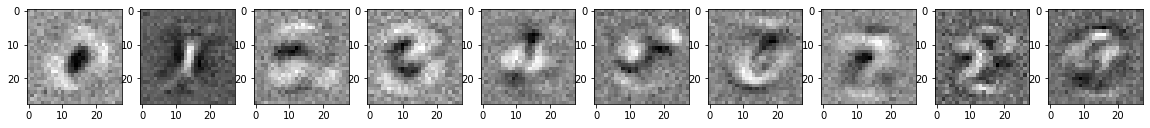

In [46]:
# Plot weights, to visualize what the model has learnt.
fig, ax = plt.subplots(1,10,figsize=(20,2))
for digit in range(10):
    ax[digit].imshow(W[:,digit].detach().view(28,28),cmap='gray')